In [1]:
import os
import ast
import json
import joblib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
results_dir = "HPC_code/rf_model_output_zones2/results"  # Directory where the results files are stored
results_files = os.listdir(results_dir)  # List all the files in the directory

# Initialize an empty list to store the results
results_list = []

for file in results_files:
    # Construct the full path to the file
    file_path = os.path.join(results_dir, file)

    # Open the file and load the results into a dictionary
    # with open(file_path, 'r') as f:
    #     result_dict = json.load(f)

    # Read file contents 
    with open(file_path, 'r') as f:
        file_contents = f.read()

    if not file_contents.strip():
        print(f"Skipping empty file: {file_path}")
        continue
    # Convert string to dictionary
    try:
        result_dict = ast.literal_eval(file_contents)
    except SyntaxError as e:
        print(f"Error parsing file: {file_path}")
        print(e)

    # Split the filename at the underscore and extract the relevant parts
    file_parts = file.split("_")
    result_dict['field'] = file_parts[0]
    result_dict['year'] = file_parts[1]
    result_dict['soil_test'] = file_parts[2]
    result_dict['phosphorus_treatment'] = file_parts[3].split('.')[0]

    # Add the dictionary to the list
    results_list.append(result_dict)

# Load the results into a pandas DataFrame
df = pd.DataFrame(results_list)

In [4]:
print(df.shape)
df.head()

(120, 9)


,model_name,num_input_params,r2,mse,features_importances,field,year,soil_test,phosphorus_treatment
0,../rf_model_output_zones2/models/16A_2018_H3A_...,22,0.458842,13.206981,"{'H3A_Al_0_2': 0.05056962096199954, 'H3A_Ca_0_...",16A,2018,H3A,np
1,../rf_model_output_zones2/models/16A_2018_H3A_...,23,0.623655,9.184711,"{'H3A_Al_0_2': 0.046355671913939564, 'H3A_Ca_0...",16A,2018,H3A,p
2,../rf_model_output_zones2/models/16A_2018_M3_n...,22,0.457693,13.235003,"{'M3_Al_0_2': 0.0533344201553255, 'M3_Ca_0_2':...",16A,2018,M3,np
3,../rf_model_output_zones2/models/16A_2018_M3_p...,23,0.630215,9.024602,"{'M3_Al_0_2': 0.0481940154254916, 'M3_Ca_0_2':...",16A,2018,M3,p
4,../rf_model_output_zones2/models/16A_2018_Ols_...,22,0.463568,13.091637,"{'Ols_Al_0_2': 0.044449594485097534, 'Ols_Ca_0...",16A,2018,Ols,np


In [5]:
# Copy dataframe 
df2 = df.copy()

# Keys to remove
keys_to_remove = ['elevation', 'slope', 'aspect', 'TOC_0_2', 'TC_0_2', 'IC_0_2', 
                  'TN_0_2', 'TOC_2_6', 'TC_2_6', 'IC_2_6', 'TN_2_6','PhosphorusTreatment']

# Remove keys  
for i, row in df2.iterrows():
    for key in keys_to_remove:
        if key in row['features_importances']:
            del row['features_importances'][key]

# Sum importances into new list
summed_importances = []
for i, row in df2.iterrows():
    summed_importances.append(sum(row['features_importances'].values()))

# Create new column    
df2['soil_test_importances'] = summed_importances

# Confirm keys were removed
df2['features_importances'].iloc[0]

{'H3A_Al_0_2': 0.05056962096199954,
 'H3A_Ca_0_2': 0.04351326798600642,
 'H3A_Fe_0_2': 0.0560877031101293,
 'H3A_K_0_2': 0.045622446331703835,
 'H3A_Mg_0_2': 0.03308798241373009,
 'H3A_P_0_2': 0.0385561072260487,
 'H3A_Al_2_6': 0.09167621274499978,
 'H3A_Ca_2_6': 0.04912107954252646,
 'H3A_Fe_2_6': 0.10949849036175768,
 'H3A_K_2_6': 0.03457363779262982,
 'H3A_Mg_2_6': 0.04069028729339548,
 'H3A_P_2_6': 0.037951764787007396,
 'Zone_1': 0.027645157322206126,
 'Zone_2': 0.0,
 'Zone_3': 8.832492730233146e-05,
 'Zone_4': 0.02060378578459155}

In [6]:
# Reshape your data
pivot_df = df.pivot_table(index=['field', 'year', 'soil_test'], columns='phosphorus_treatment', values='r2')

# Subtract the 'np' values from the 'p' values
pivot_df['r2_diff'] = pivot_df['p'] - pivot_df['np']

# Reset the index to return the dataframe to a similar format as before
pivot_df = pivot_df.reset_index()

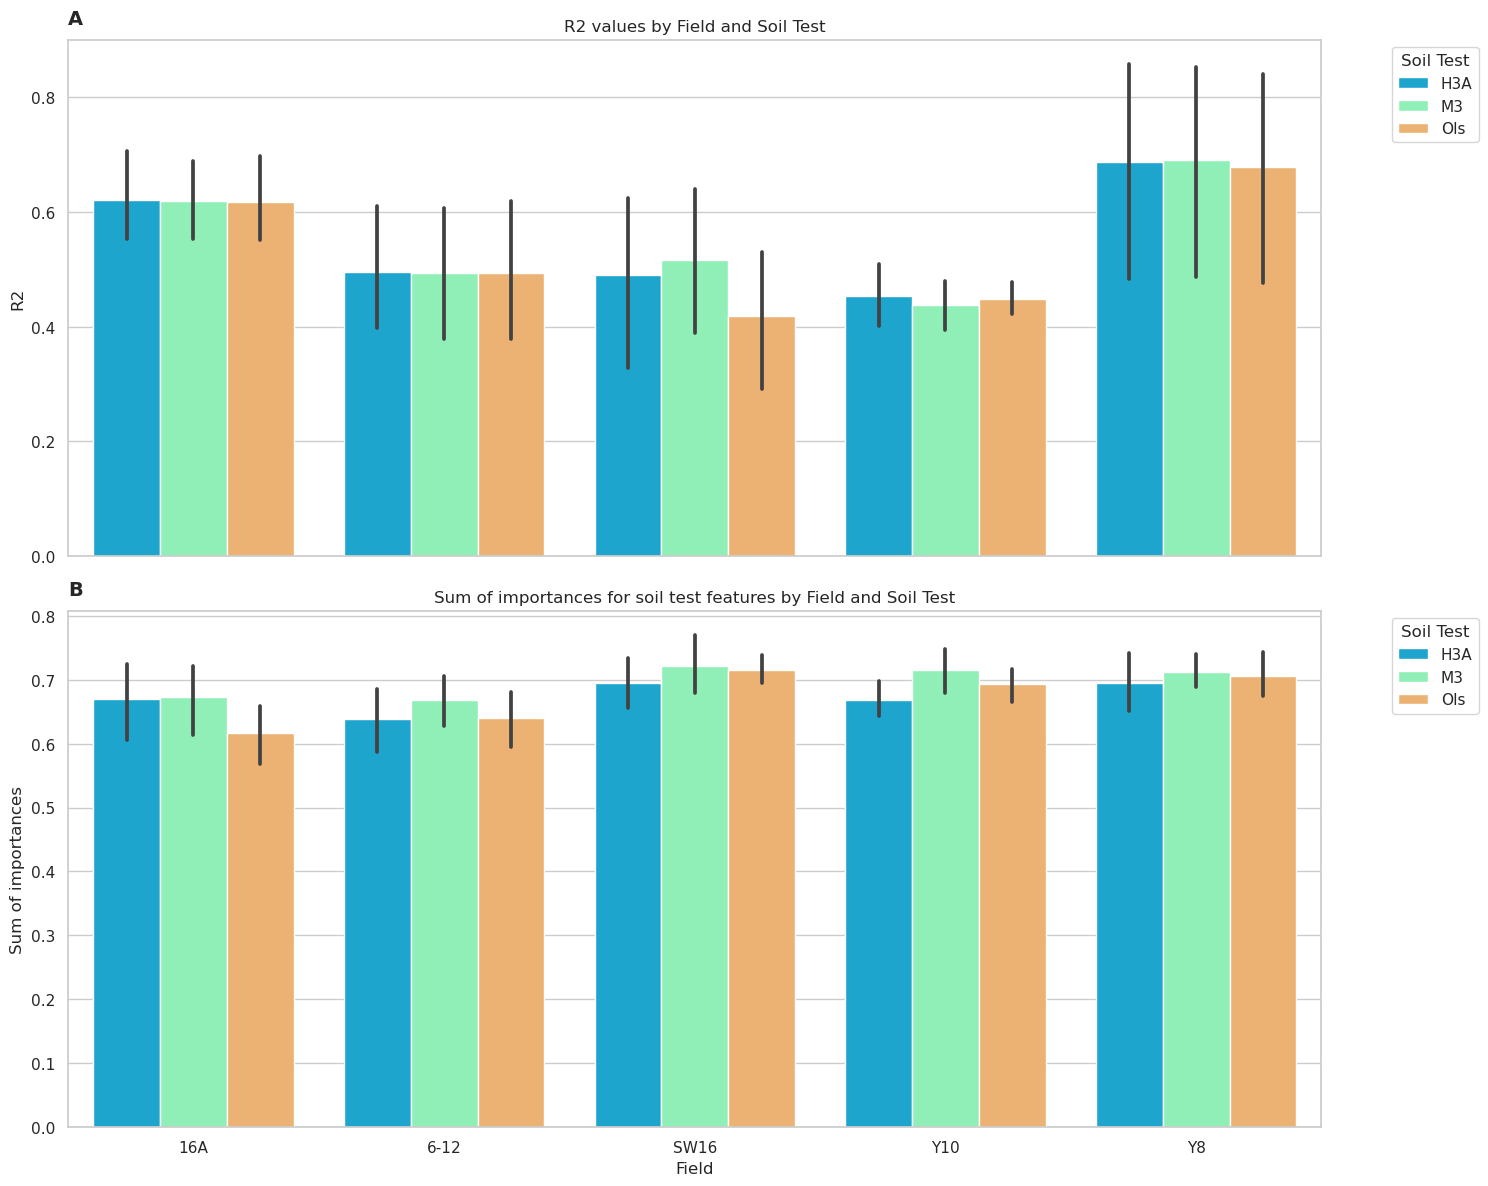

In [54]:
# Create figure and axes
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 12), sharex=True)

# Plot 1 
sns.barplot(ax=ax1, data=df, x='field', y='r2', hue='soil_test', palette='rainbow')
ax1.set_title('R2 values by Field and Soil Test')
ax1.set_ylabel('R2')
ax1.legend(title='Soil Test',bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.set_xlabel('')
ax1.text(0, 1.03, 'A', transform=ax1.transAxes, 
       fontsize=14, fontweight='bold')

# Plot 2
sns.barplot(ax=ax2, data=df2, x='field', y='soil_test_importances', hue='soil_test', palette='rainbow')  
ax2.set_title('Sum of importances for soil test features by Field and Soil Test')
ax2.set_ylabel('Sum of importances')
ax2.set_xticks(range(5))
# ax2.set_xticklabels(range(1,6))
ax2.legend(title='Soil Test',bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.set_xlabel('Field')
ax2.text(0, 1.03, 'B', transform=ax2.transAxes, 
       fontsize=14, fontweight='bold')

# Adjust layout 
fig.tight_layout()
# plt.savefig('Out/Figures/Full_RF_R2.jpg', bbox_inches = 'tight', dpi = 300)

In [52]:
results_dir = "HPC_code/rf_model_output_zones2/results"
models_dir = "HPC_code/rf_model_output_zones2/models"
X_dir = "HPC_code/rf_model_output_zones2/X"

# Load all results dicts
results = []
for file_path in os.listdir(results_dir):
    # print(file_path)
    with open(os.path.join(results_dir, file_path)) as f:
        results.append(json.load(f))

for result in results:

  # Extract model path
  model_path = result['model_name'].split('/')[-1]
  
  # Load model
  model = joblib.load(os.path.join(models_dir, model_path))
  result['model'] = model

  # Construct X_train path from model path
  x_train_path = model_path.replace('models', 'X').replace('joblib', 'csv')

  # Load X_train
  x_train = pd.read_csv(os.path.join(X_dir, x_train_path))
  result['X_train'] = x_train

In [9]:
len(results)

120

In [10]:
import matplotlib.patches as mpatches

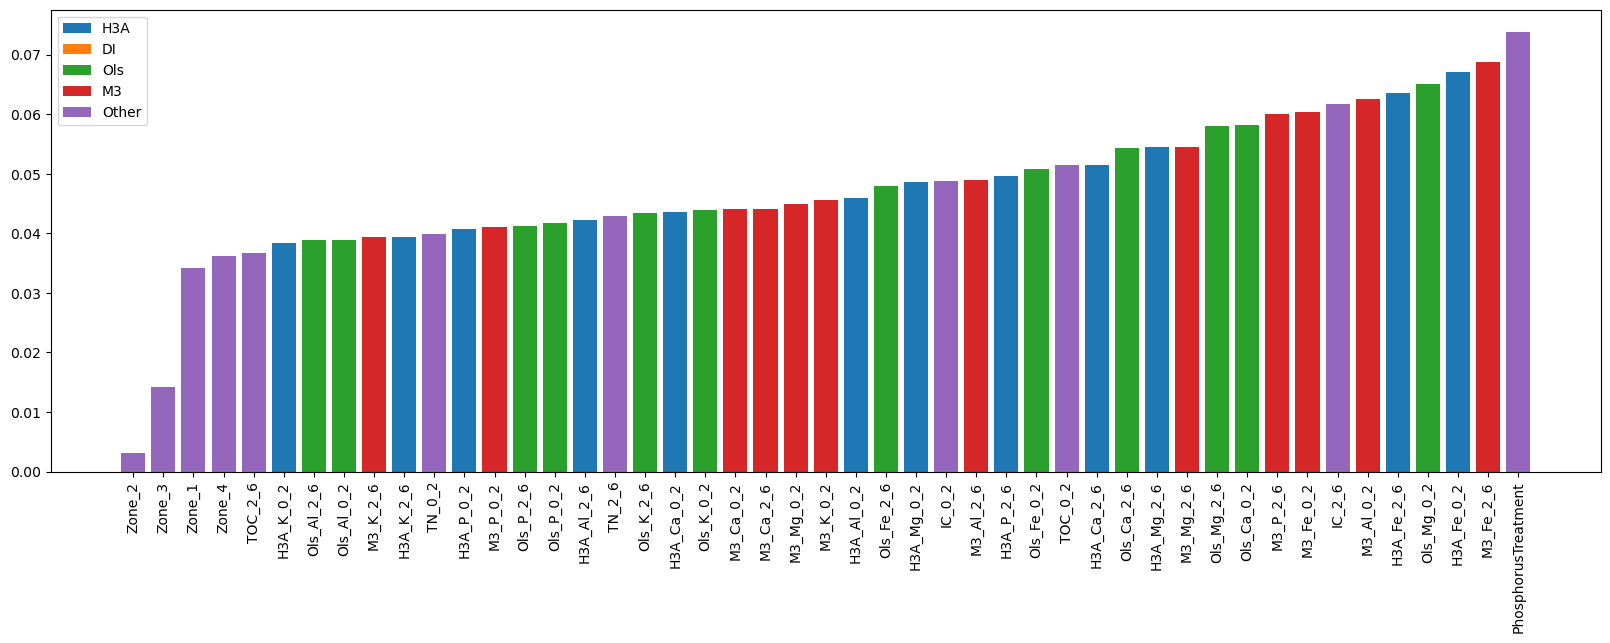

In [12]:
# Extract feature names
feature_names = set() 
for result in results:
    # print(result['model_name'])
    feature_names.update(result['features_importances'].keys())

# Initialize dicts
avg_importances = {f: 0 for f in feature_names}
feature_counts = {f: 0 for f in feature_names}

for result in results:

  for f, imp in result['features_importances'].items():
    
    # Increment count for this feature
    feature_counts[f] += 1
    
    # Add importance contribution
    avg_importances[f] += imp

# Calculate average based on counts 
for f in avg_importances:
  avg_importances[f] /= feature_counts[f] 

# Plot
# Sort the importances
sorted_importances = dict(sorted(avg_importances.items(), key=lambda x: x[1]))

# Get sorted keys and values 
feat_names = list(sorted_importances.keys())
importances = list(sorted_importances.values())

# Dictionary of colors 
color_map = {'H3A': 'C0', 'DI': 'C1', 'Ols': 'C2', 'M3': 'C3', 'Other': 'C4'} 

# Get colors for each bar
colors = []
for feat in feat_names:
    substring = feat.split('_')[0]
    if substring in color_map:
        colors.append(color_map[substring])
    else:
        colors.append(color_map['Other'])

fig, ax = plt.subplots(figsize=(20, 6))

# Plot bars
plt.bar(range(len(importances)), importances, color=colors)

# Set xtick labels  
plt.xticks(range(len(feat_names)), feat_names, rotation=90)

# Legend
legend_elements = [mpatches.Patch(facecolor=color_map[x], label=x) for x in color_map]
plt.legend(handles=legend_elements)
plt.savefig('Output/Figures/All_feature_importances.jpg', bbox_inches = 'tight', dpi = 300)

In [13]:
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
import sklearn

In [14]:
sklearn.__version__

'1.3.0'

In [15]:
def extract_data():
    plotting_df = pd.DataFrame()
    temp_dfs = []
    # Filter df 
    df_odd = df[df.index % 2 != 0]
    # Iterate through fields
    for i, field in enumerate(df_odd['field'].unique()):
      temp_df = pd.DataFrame()
      # Filter to rows for this field
      field_df = df_odd[(df_odd['field'] == field)]
      
      # Plot on field's axis
      for j in field_df.index:
        temp_df = pd.DataFrame()
        # Generate PDP
        display = PartialDependenceDisplay.from_estimator(results[j]['model'], 
                                                          results[j]['X_train'],
                                                          ['PhosphorusTreatment']) 
    
        # Extract data
        x = list(display.pd_results[0].values())[1][0]
        y = list(display.pd_results[0].values())[2][0]
        year = df_odd.loc[j, 'year']
        temp_df['x'] = x.tolist()
        temp_df['y'] = y.tolist()
        temp_df['y'] = [y*25.4016 for y in temp_df['y']] #Converting from bu/acre to kg/ha
        temp_df['year'] = year
        temp_df['field'] = field
        temp_dfs.append(temp_df)
    
    plotting_df = pd.concat(temp_dfs)

    return plotting_df

/home/bostevens/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/inspection/_plot/partial_dependence.py:1289: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _, ax = plt.subplots()


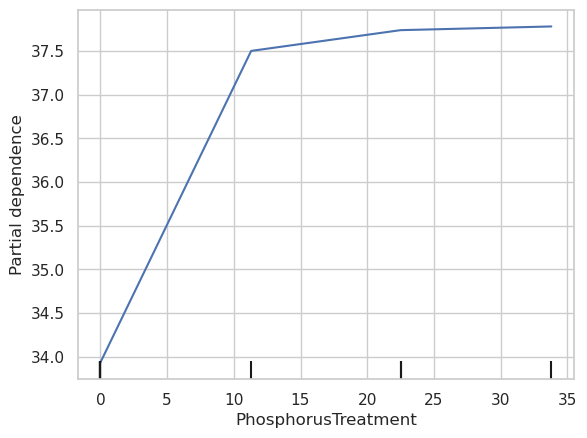

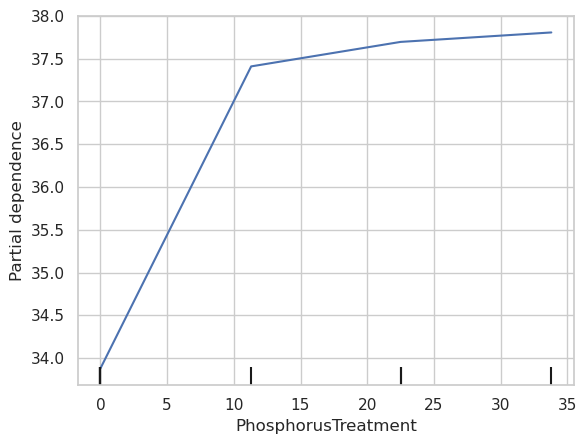

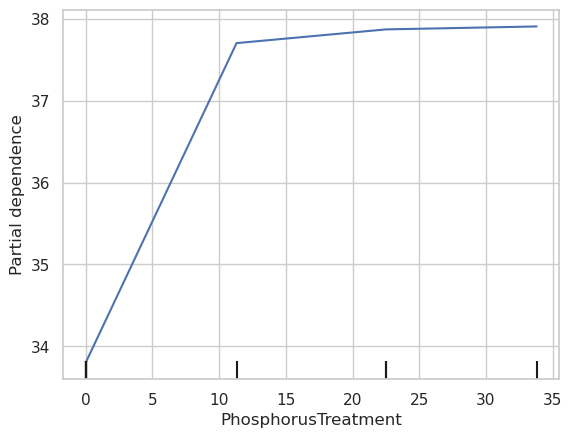

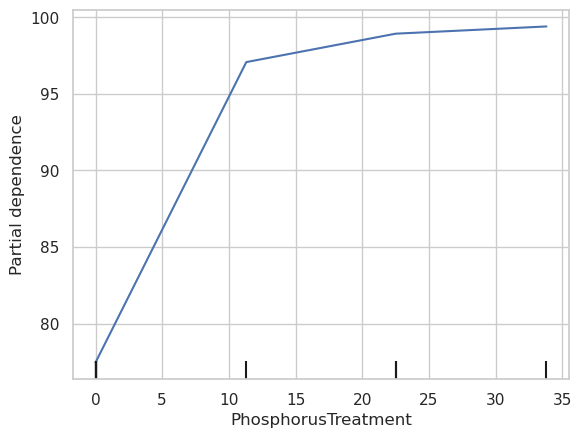

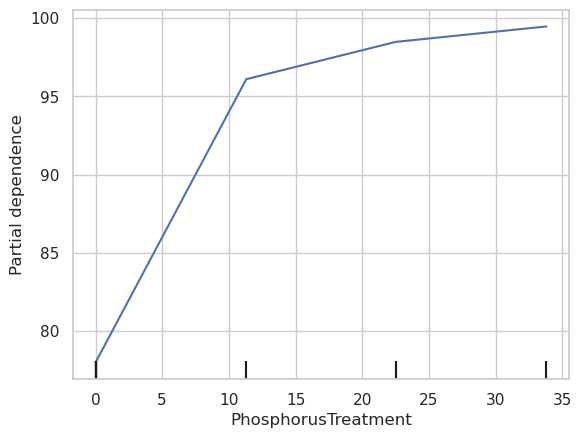

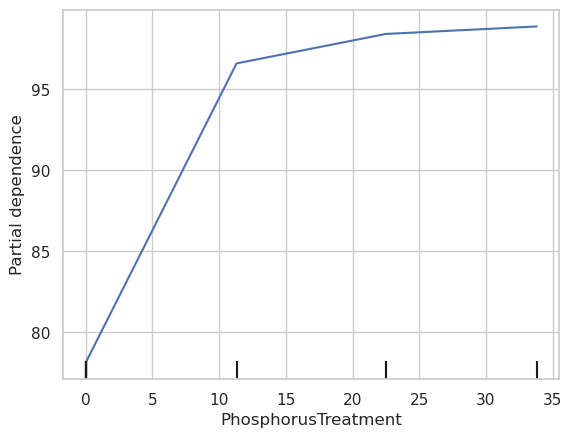

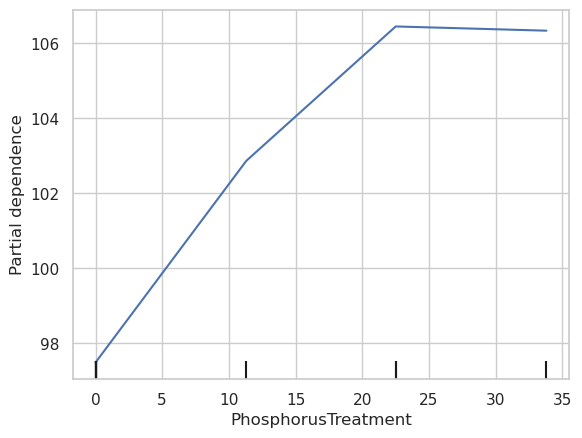

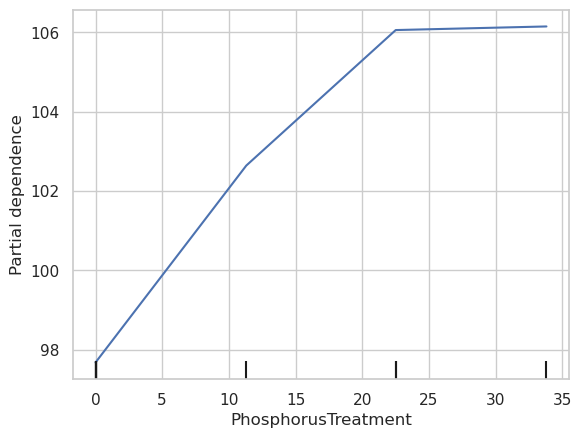

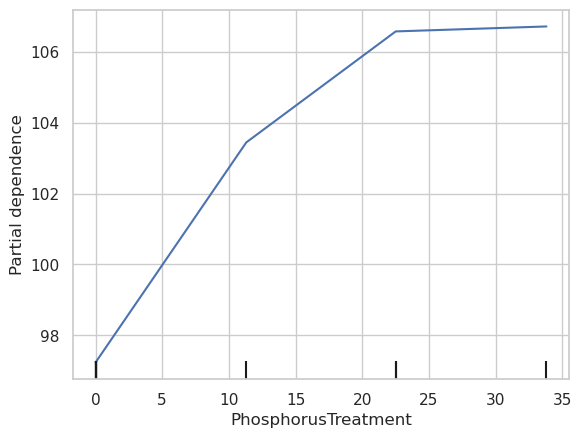

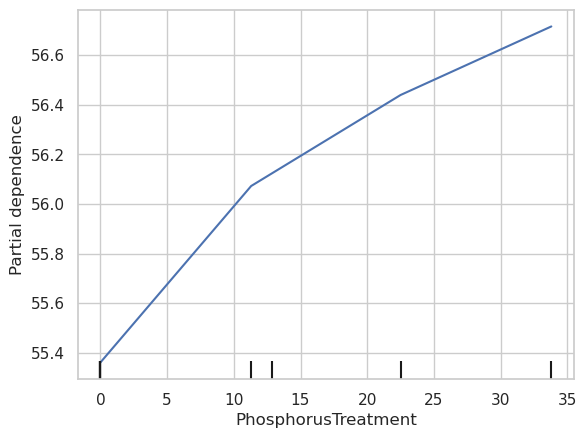

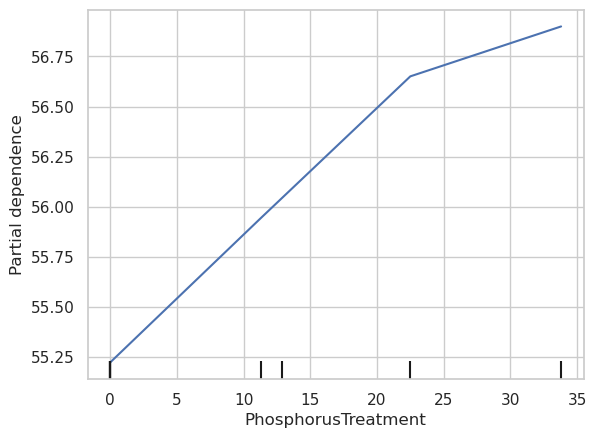

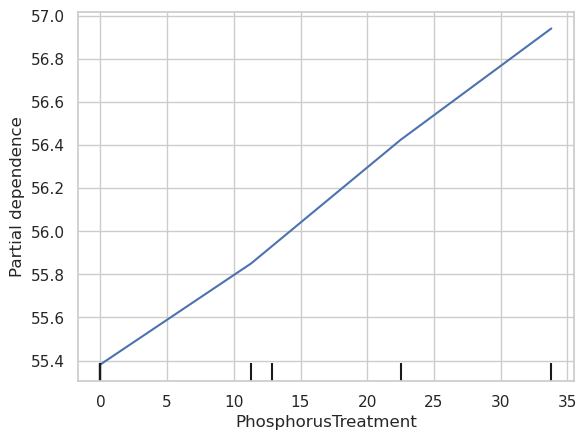

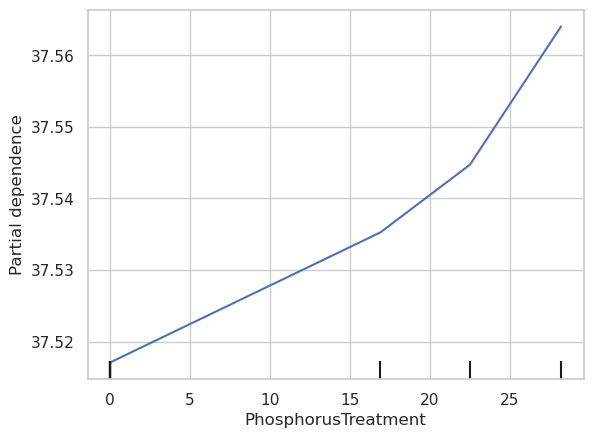

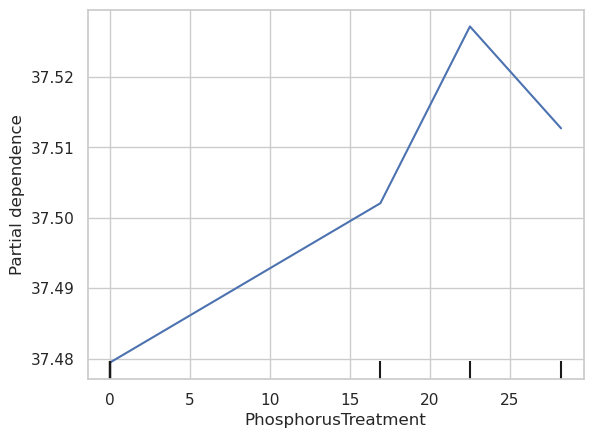

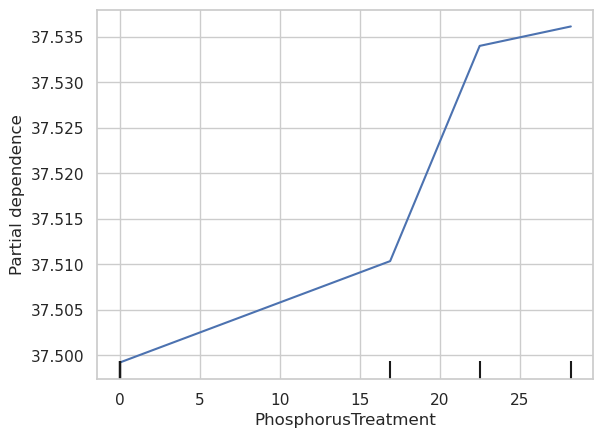

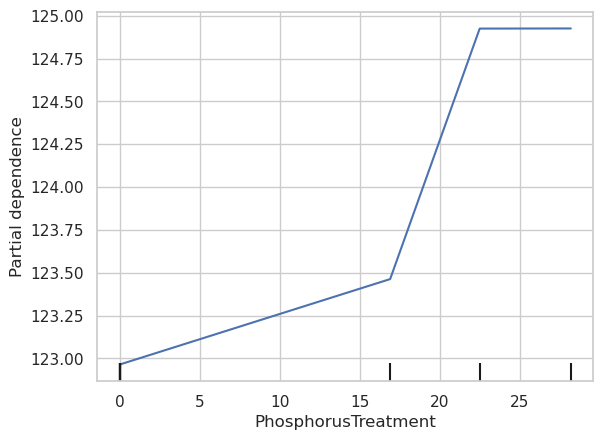

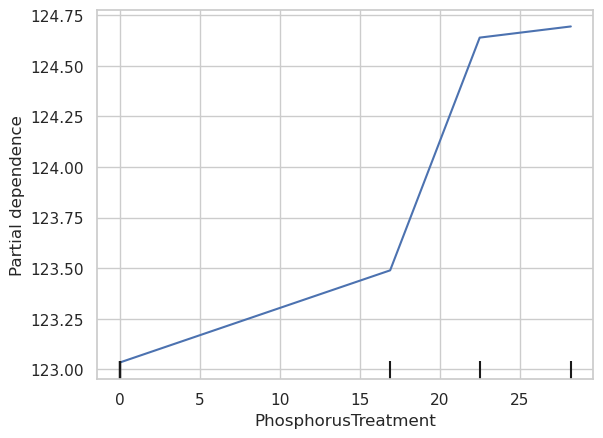

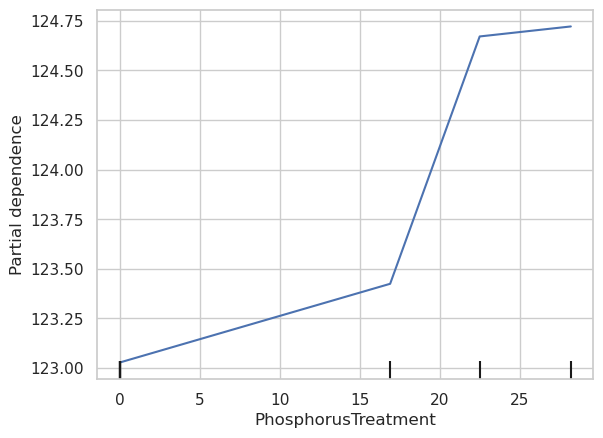

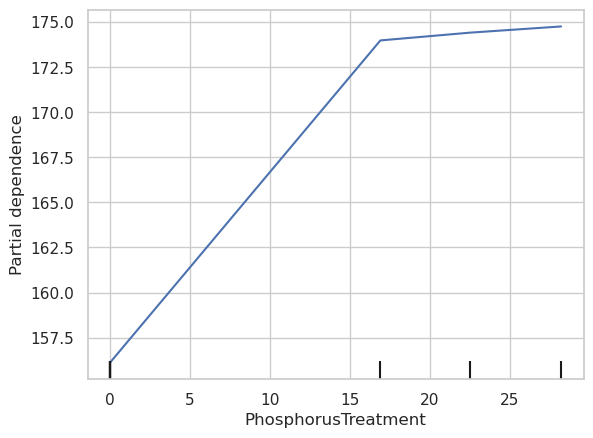

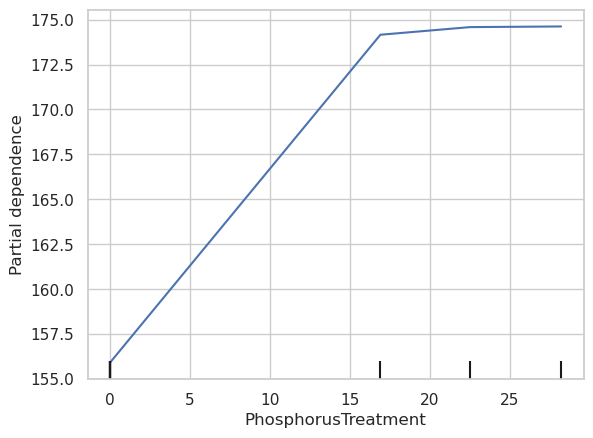

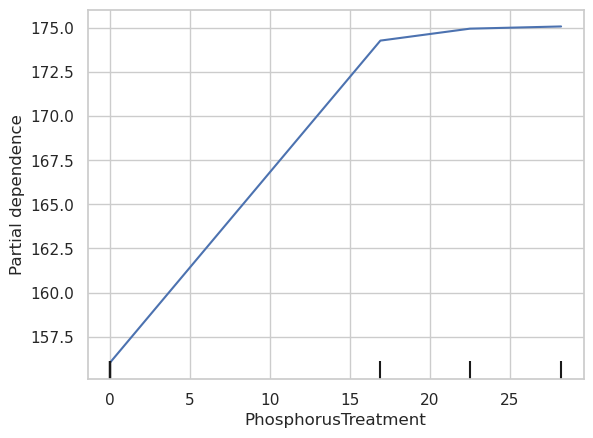

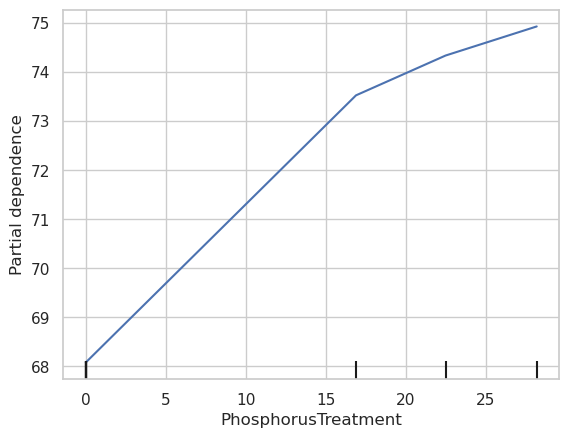

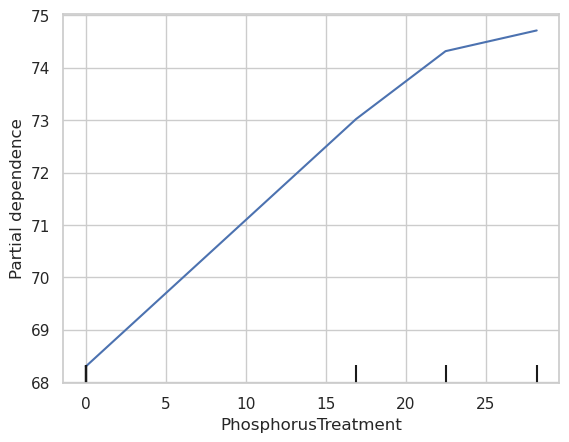

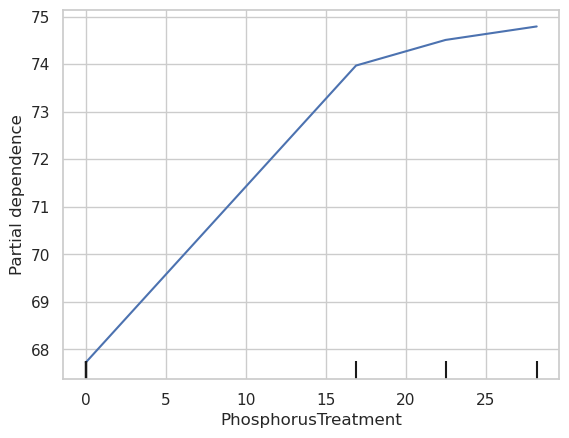

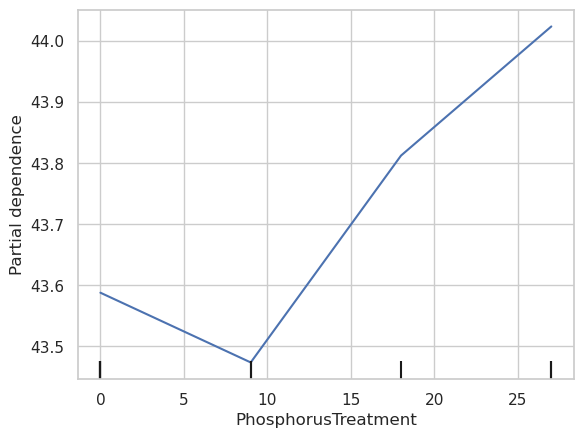

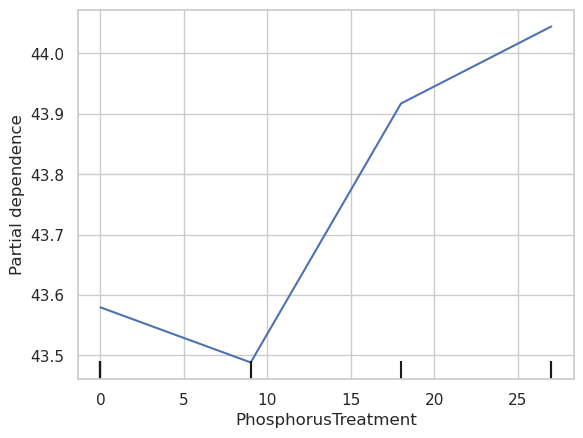

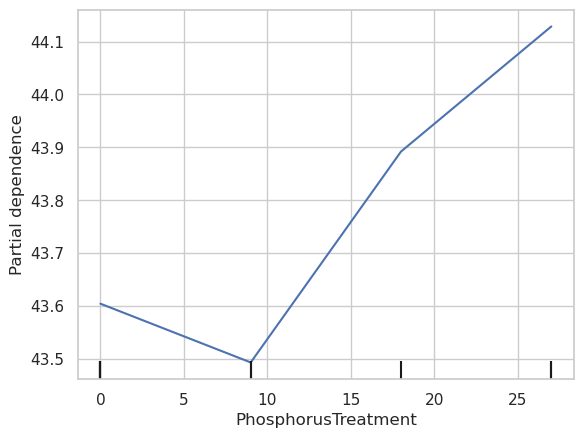

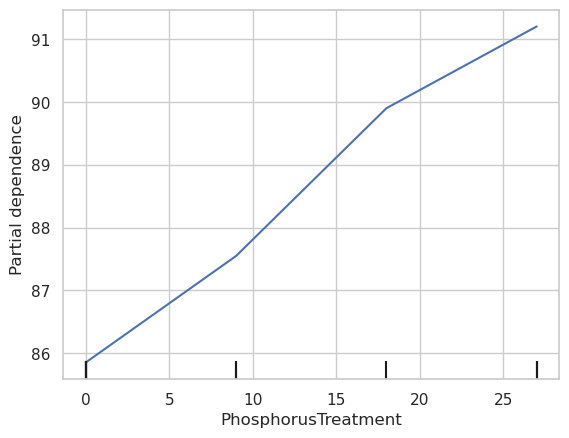

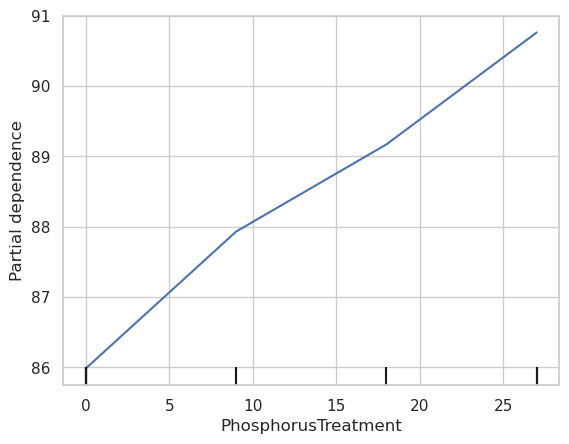

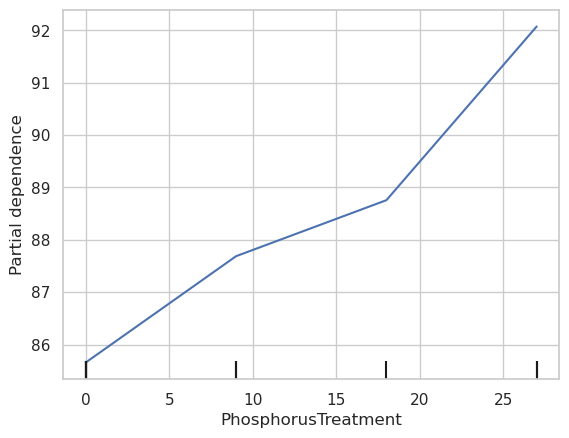

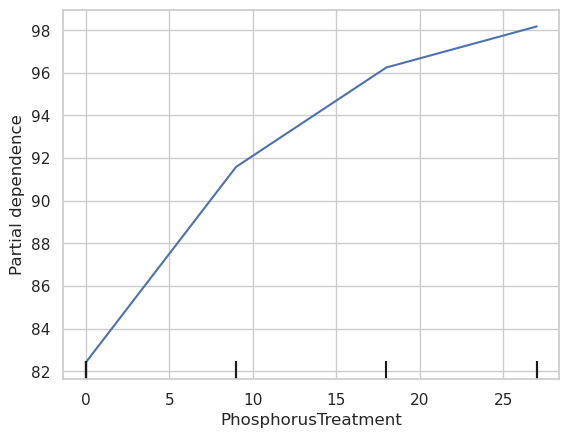

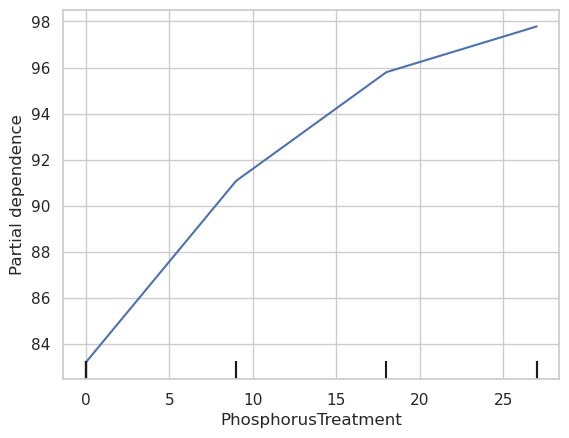

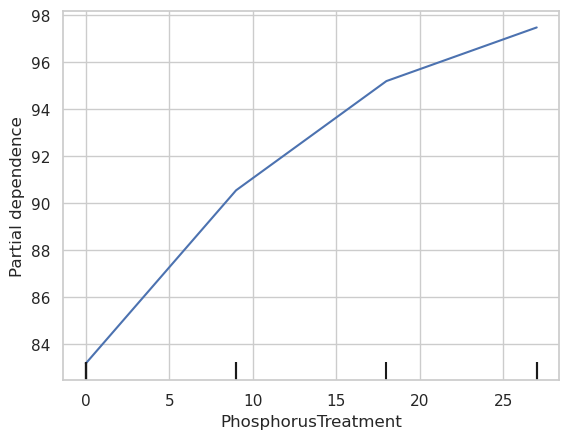

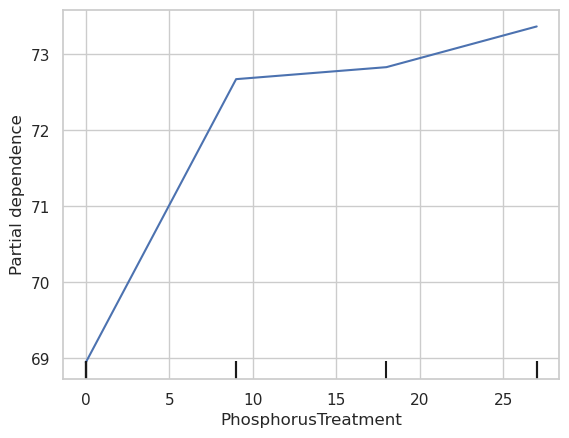

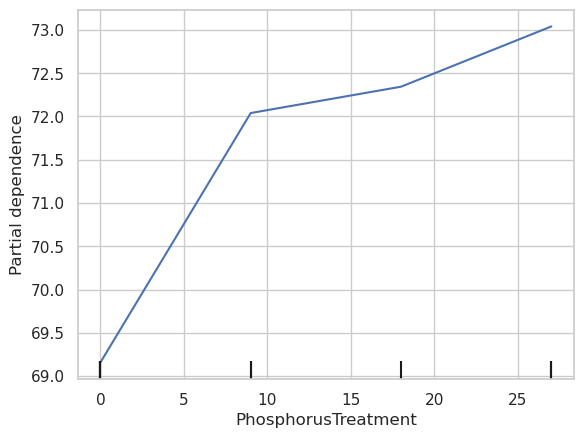

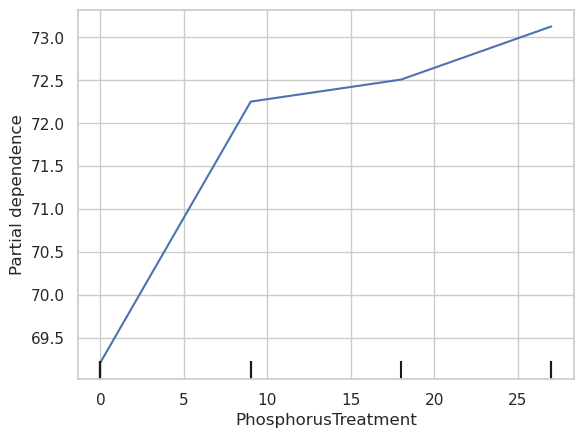

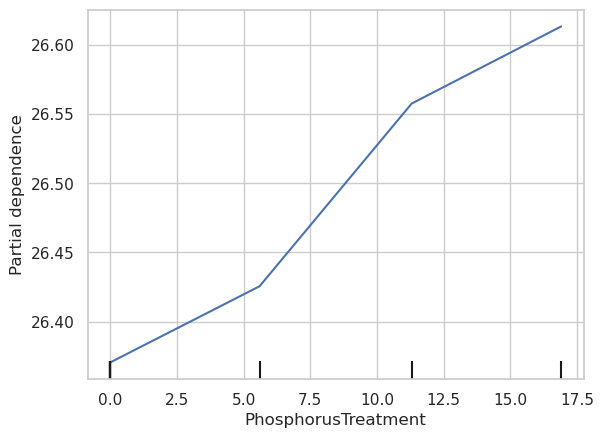

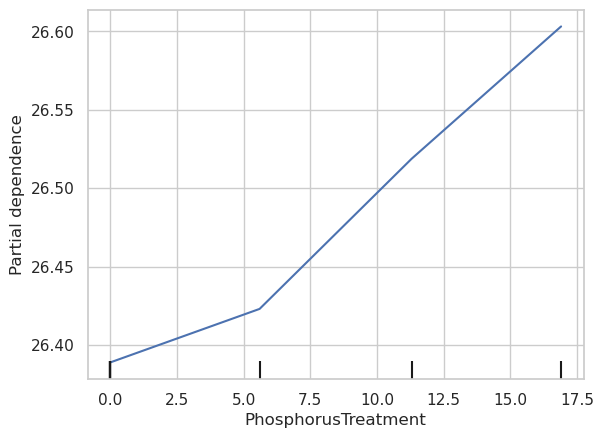

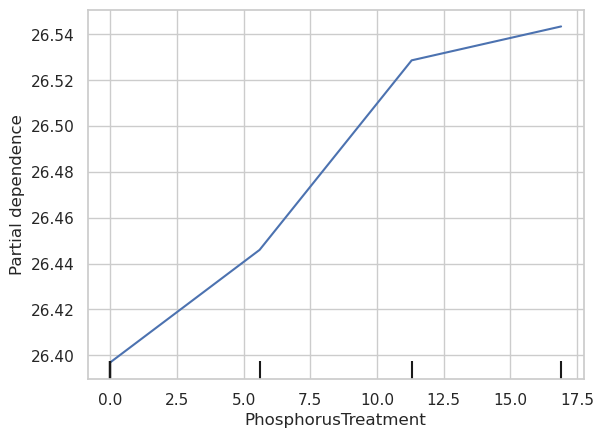

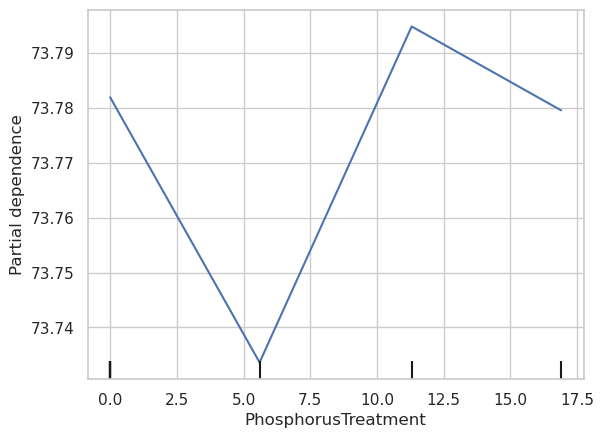

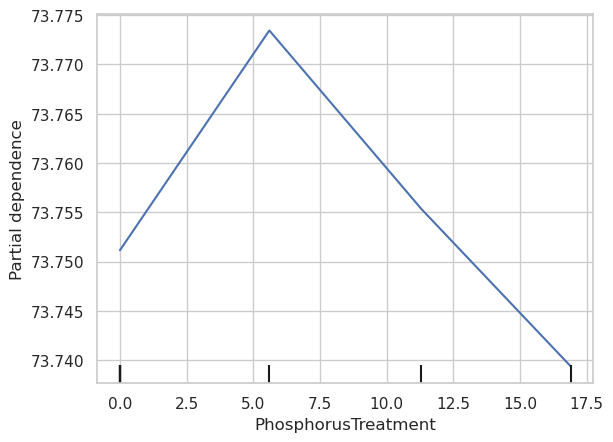

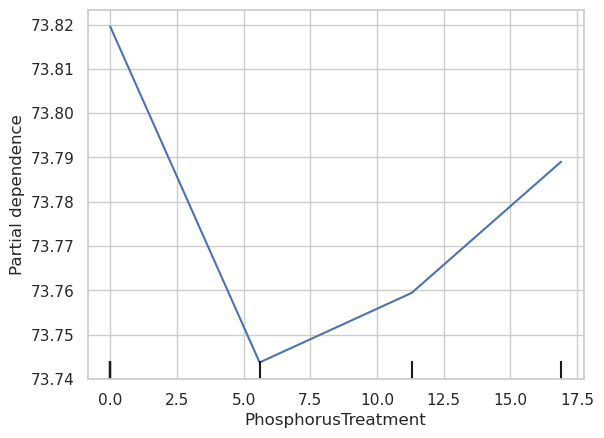

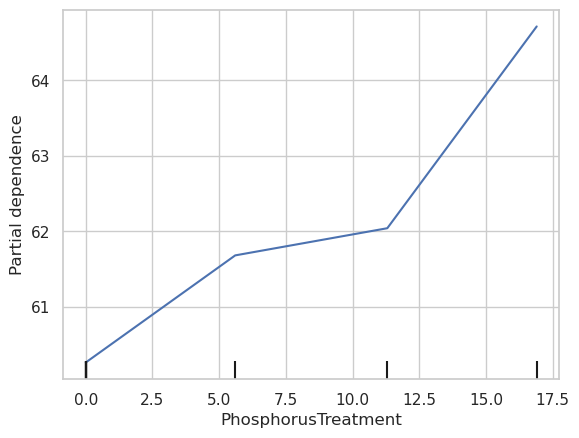

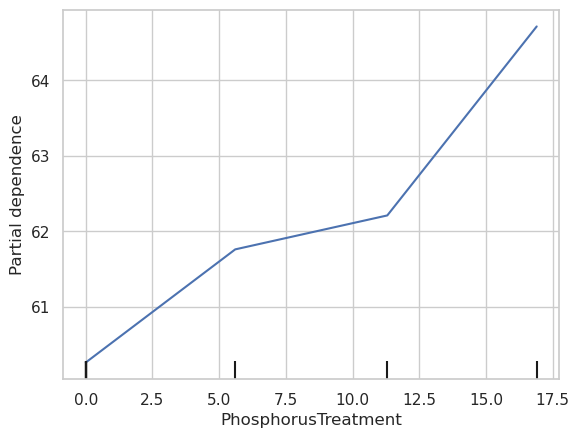

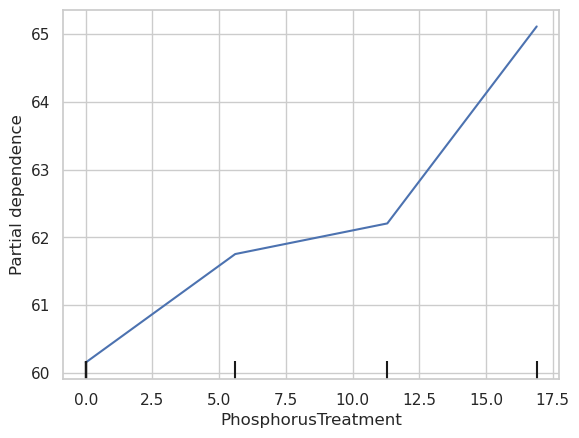

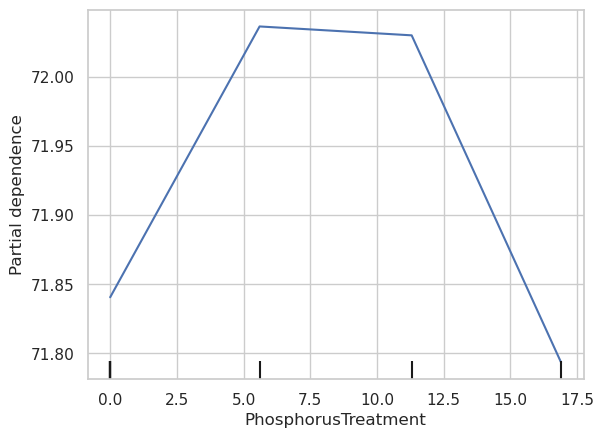

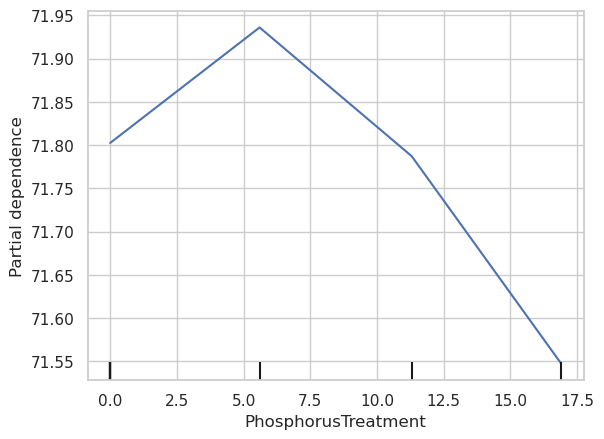

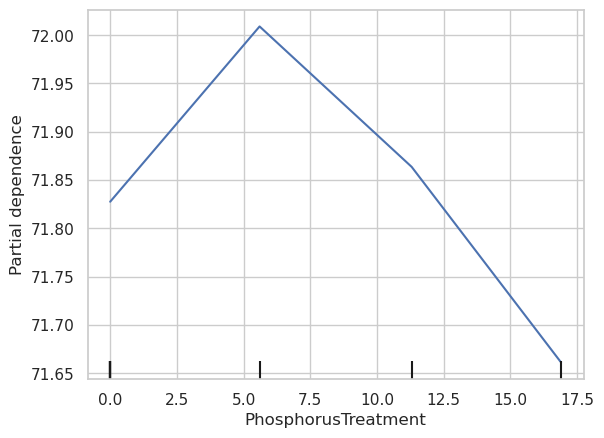

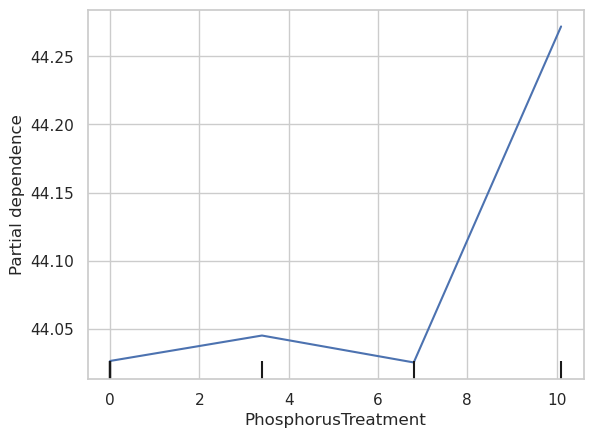

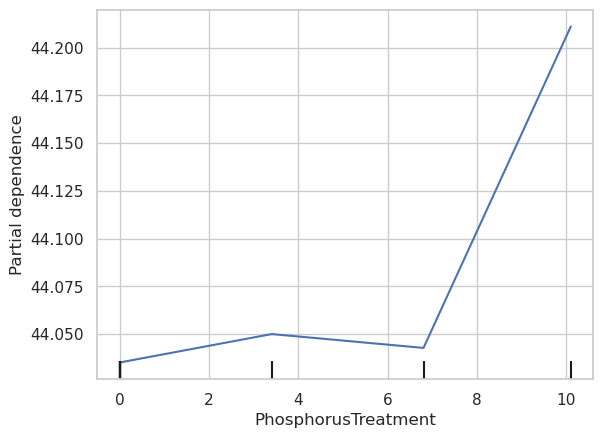

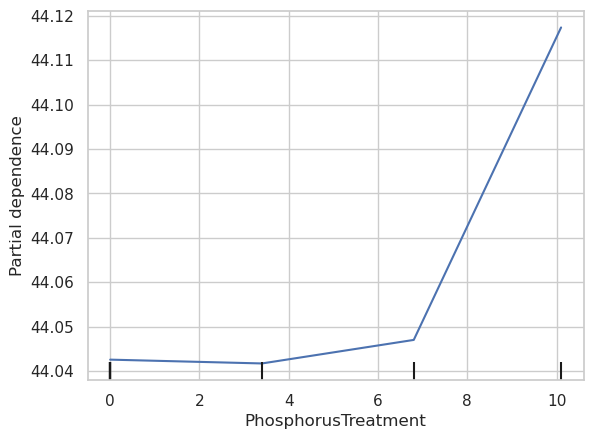

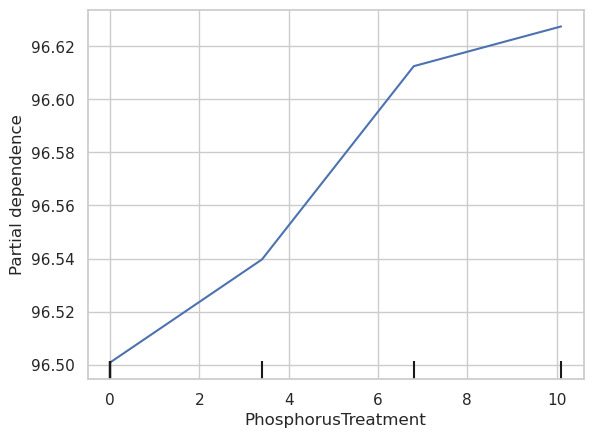

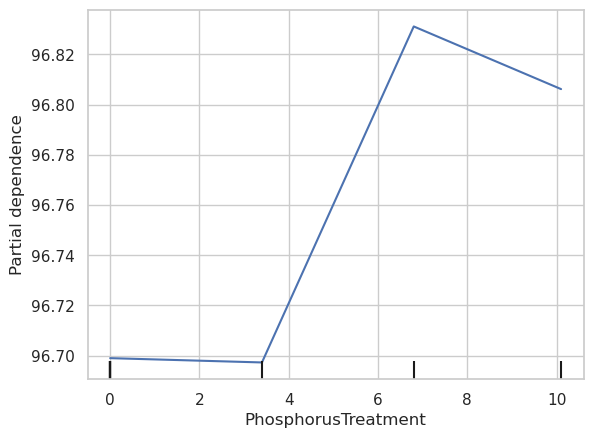

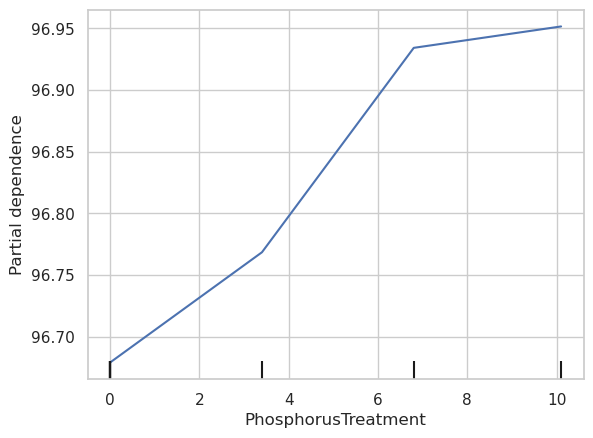

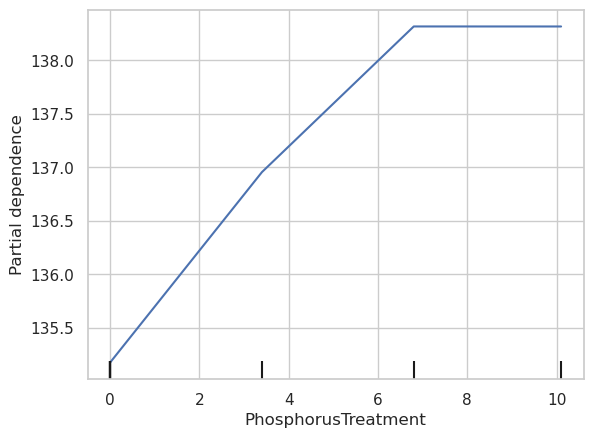

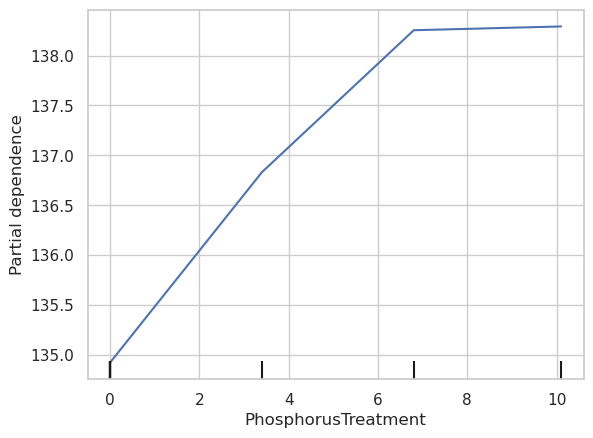

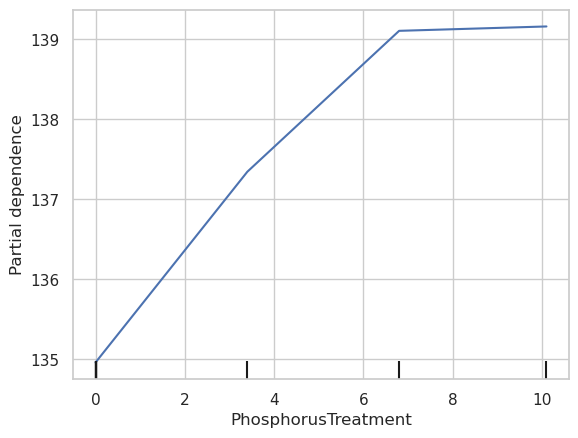

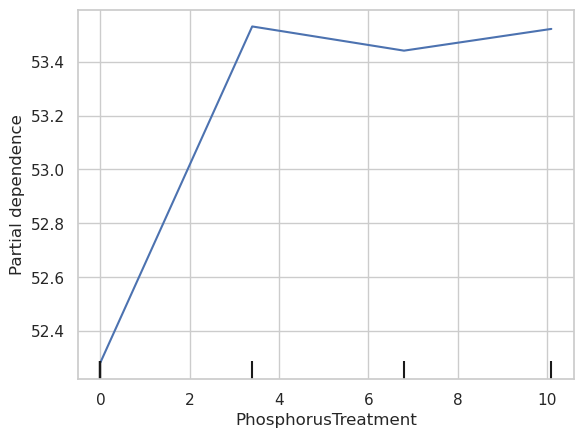

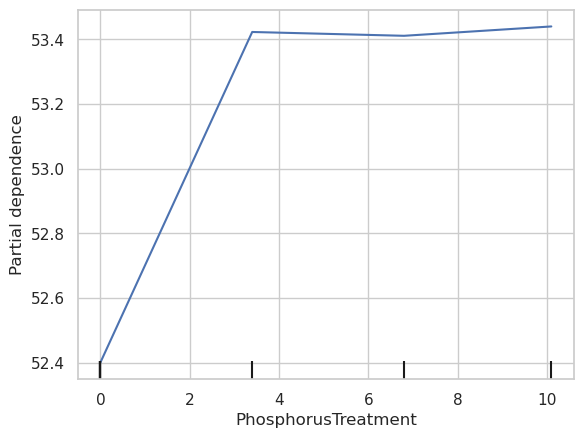

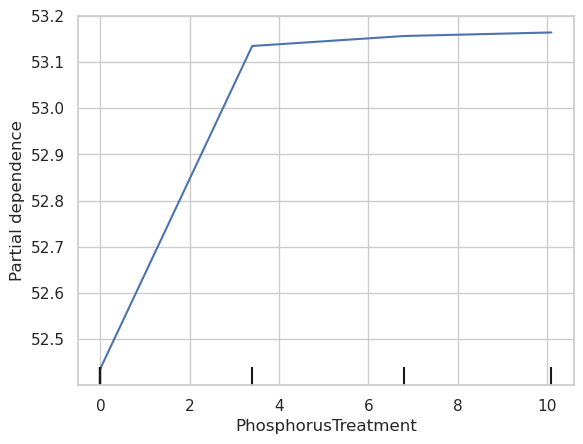

In [53]:
plotting_df = extract_data()

In [17]:
plotting_df.shape

(240, 4)

In [18]:
from matplotlib import gridspec

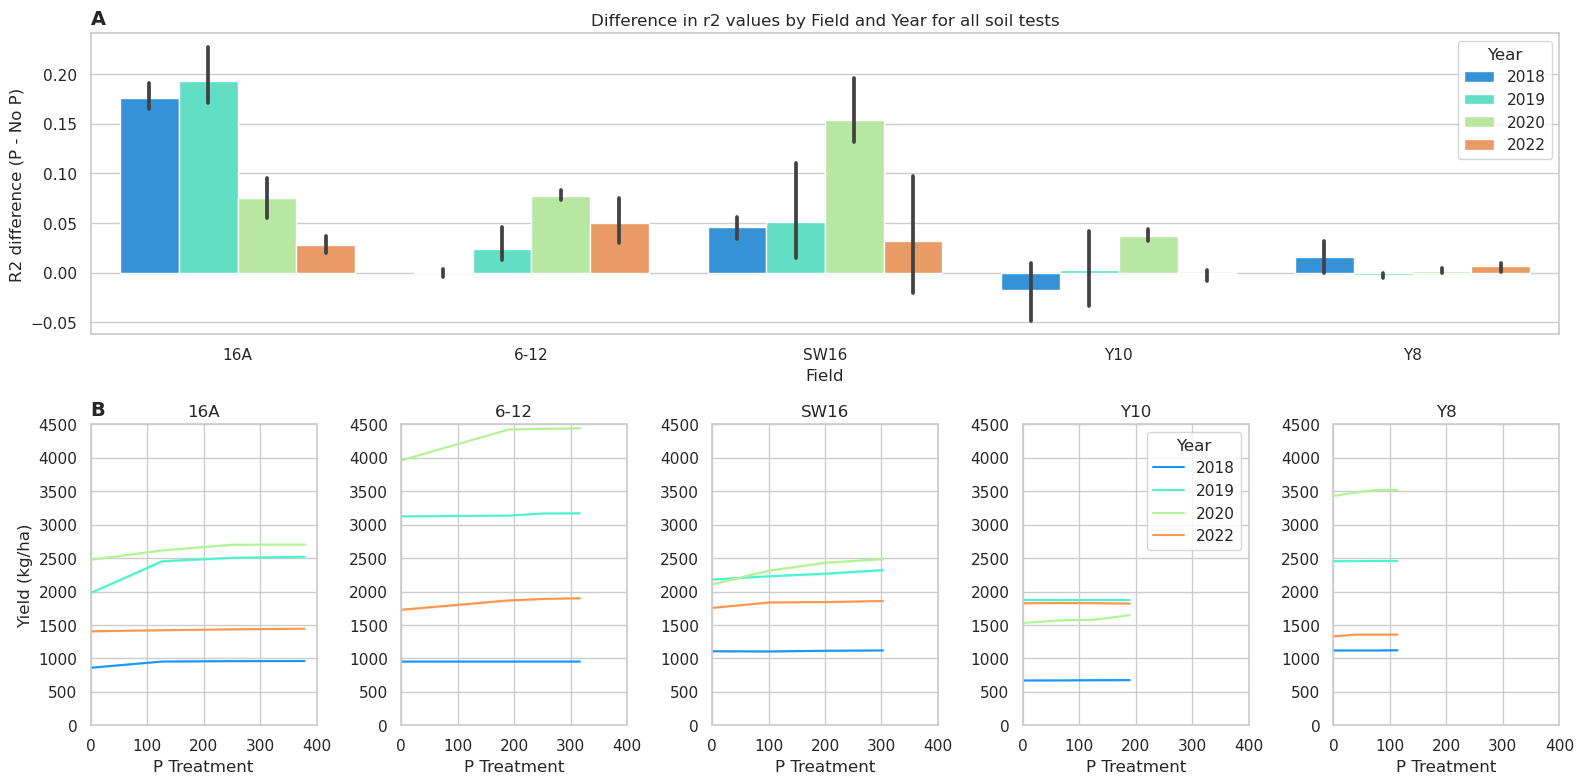

In [50]:
sns.set(style="whitegrid")

# Reshape your data
pivot_df = df.pivot_table(index=['field', 'year', 'soil_test'], columns='phosphorus_treatment', values='r2')

# Subtract the 'np' values from the 'p' values
pivot_df['r2_diff'] = pivot_df['p'] - pivot_df['np']

# Reset the index to return the dataframe to a similar format as before
pivot_df = pivot_df.reset_index()

# Create figure 
fig = plt.figure(figsize=(16,8))

# Define subplot grid
gs = gridspec.GridSpec(nrows=2, ncols=5) 

# Top subplot 
ax0 = fig.add_subplot(gs[0, :])

# Bottom subplots
ax1 = fig.add_subplot(gs[1,0]) 
ax2 = fig.add_subplot(gs[1,1])
ax3 = fig.add_subplot(gs[1,2])
ax4 = fig.add_subplot(gs[1,3])
ax5 = fig.add_subplot(gs[1,4])

sns.barplot(data=pivot_df, x='field', y='r2_diff', hue='year', palette='rainbow', ax = ax0)
ax0.set_title(f'Difference in r2 values by Field and Year for all soil tests')
ax0.set_ylabel('R2 difference (P - No P)')
ax0.set_xlabel('Field')
ax0.legend(title='Year')
# ax0.set_xticks(range(5), range(1, 6)) 

ax0.text(0, 1.03, 'A', transform=ax0.transAxes, 
      fontsize=14, fontweight='bold')

fields = plotting_df['field'].unique()

# Plot each field separately 
for i, ax in enumerate([ax1, ax2, ax3, ax4, ax5]):

  # Filter data 
  field_df = plotting_df[plotting_df['field'] == fields[i]].copy()
  # Converting to metric
  field_df['x_metric'] = field_df['x']*0.45359/0.0404686

  # Plot field's data
  sns.lineplot(data=field_df, x='x_metric', y='y', hue='year', palette='rainbow', ax=ax)
  ax.set_xlabel('P Treatment')
  ax.set_title(fields[i])
  ax.set_ylim(0, 4500)
  ax.set_xlim(0, 400)
  ax.set_ylabel('')
  if i == 3:
    ax.legend(title='Year')
  else: 
    ax.get_legend().remove()
# Set title
ax1.set_ylabel('Yield (kg/ha)')
ax1.text(0, 1.03, 'B', transform=ax1.transAxes, 
       fontsize=14, fontweight='bold')

# Finalize plot  
plt.tight_layout()
plt.savefig('Output/Figures/Combined_Full_RF_R2Diff_P_PDP.jpg', bbox_inches = 'tight', dpi = 300)

# Calculating recommended P application

In [20]:
from sklearn.linear_model import LinearRegression
import numpy as np

In [27]:
# Define function to calculate recommended P application
def calculate_recommended_P(a, b, Y_max, X_max):
    if b > 0:
        P_recommended = (0.95 * Y_max - a) / b
        P_recommended = max(P_recommended, 0)  # Set to 0 if negative
        P_recommended = min(P_recommended, X_max)  # Set to X_max if above
    else:
        P_recommended = 0  # Set to 0 if slope is negative
    return P_recommended

# Initialize a list to store recommended P application rates
recommended_P_list = []

# Loop over each field and each year
for field in fields:
    for year in plotting_df['year'].unique():
        # Filter data for the specific field and year
        field_year_df = plotting_df[(plotting_df['field'] == field) & (plotting_df['year'] == year)].copy()
        
        # Convert units to metric
        field_year_df.loc[:, 'x_metric'] = field_year_df['x']*0.45359/0.0404686

        # Extract x (P rate) and y (Yield)
        X = field_year_df['x_metric'].values.reshape(-1, 1)
        Y = field_year_df['y'].values

        # Perform linear regression
        model = LinearRegression()
        model.fit(X, Y)
        
        # Extract intercept and slope
        a = model.intercept_
        b = model.coef_[0]
        
        # Calculate the recommended P application rate
        P_recommended = calculate_recommended_P(a, b, np.max(Y), np.max(X))
        
        # Append result to list
        recommended_P_list.append({'Field': field, 'Year': year, 'Recommended_P': P_recommended})

# Convert the list of dictionaries to a DataFrame for easier manipulation and presentation
recommended_P_df = pd.DataFrame(recommended_P_list)

# Save or print the DataFrame as needed
print(recommended_P_df)

   Field  Year  Recommended_P
0    16A  2018     112.292722
1    16A  2019     216.272129
2    16A  2020     109.143765
3    16A  2022       0.000000
4   6-12  2018       0.000000
5   6-12  2019       0.000000
6   6-12  2020     133.009515
7   6-12  2022     122.655116
8   SW16  2018       0.000000
9   SW16  2019      91.364231
10  SW16  2020     179.460119
11  SW16  2022       0.000000
12   Y10  2018       0.000000
13   Y10  2019       0.000000
14   Y10  2020      77.682384
15   Y10  2022       0.000000
16    Y8  2018       0.000000
17    Y8  2019       0.000000
18    Y8  2020       0.000000
19    Y8  2022       0.000000


In [28]:
recommended_P_df[['Field','Recommended_P']].groupby(['Field']).mean()

,Recommended_P
Field,
16A,109.427154
6-12,63.916158
SW16,67.706088
Y10,19.420596
Y8,0.000000


In [29]:
# Treatments dictionary with medium treatment value for each field
treatments = {
    "16A": {"Medium": {"value": 22.5}},
    "6-12": {"Medium": {"value": 22.5}},
    "Y10": {"Medium": {"value": 11.3}},
    "Y8": {"Medium": {"value": 6.8}},
    "SW16": {"Medium": {"value": 18}}
}

# Function to convert values to metric units
def convert_to_metric(value):
    return value * 0.45359 / 0.0404686

# Convert medium treatment values to metric units
for field in treatments:
    treatments[field]['Medium']['value'] = convert_to_metric(treatments[field]['Medium']['value'])

# Add new columns to DataFrame
recommended_P_df['Soil_Test_Recommended_P'] = recommended_P_df['Field'].map(lambda x: treatments.get(x, {}).get('Medium', {}).get('value', None))
recommended_P_df['Percent_Fertilizer_Rate'] = (recommended_P_df['Recommended_P'] / recommended_P_df['Soil_Test_Recommended_P']) * 100

recommended_P_df.to_csv('Output/Tables/Table S1.csv')
(round(recommended_P_df, 2))

,Field,Year,Recommended_P,Soil_Test_Recommended_P,Percent_Fertilizer_Rate
0,16A,2018,112.29,252.19,44.53
1,16A,2019,216.27,252.19,85.76
2,16A,2020,109.14,252.19,43.28
3,16A,2022,0.00,252.19,0.00
4,6-12,2018,0.00,252.19,0.00
5,6-12,2019,0.00,252.19,0.00
6,6-12,2020,133.01,252.19,52.74
7,6-12,2022,122.66,252.19,48.64
8,SW16,2018,0.00,201.75,0.00
9,SW16,2019,91.36,201.75,45.29


In [30]:
recommended_P_df[['Field','Percent_Fertilizer_Rate']].groupby('Field').mean()

,Percent_Fertilizer_Rate
Field,
16A,43.390764
6-12,25.344449
SW16,33.559070
Y10,15.333413
Y8,0.000000


Coefficient (b): -0.02286271969091123
Intercept (a): 1827.1331086335977
Mean squared error: 10.115330203337097
Coefficient of determination (R2): 0.2051701409842288
Recommended P: 0


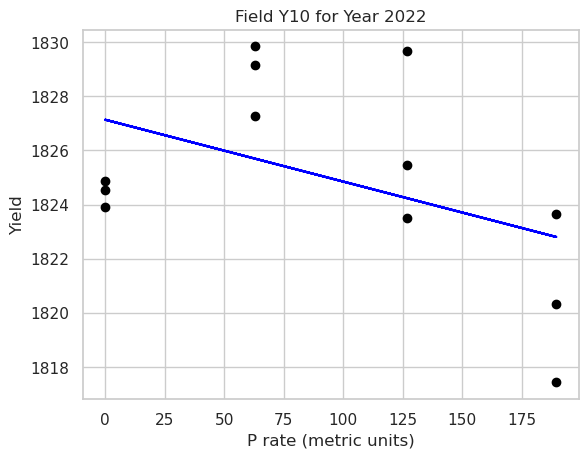

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Filter data for field "Y10" and year 2022
field_year_df = plotting_df[(plotting_df['field'] == 'Y10') & (plotting_df['year'] == '2022')].copy()

# Convert units to metric
field_year_df['x_metric'] = field_year_df['x']*0.45359/0.0404686

# Extract x (P rate in metric units) and y (Yield)
X = field_year_df['x_metric'].values.reshape(-1, 1)
Y = field_year_df['y'].values

# Perform linear regression
model = LinearRegression()
model.fit(X, Y)

# Predict Y based on X
Y_pred = model.predict(X)

# Calculate and print model diagnostics
print("Coefficient (b):", model.coef_[0])
print("Intercept (a):", model.intercept_)
print("Mean squared error:", mean_squared_error(Y, Y_pred))
print("Coefficient of determination (R2):", r2_score(Y, Y_pred))

# Calculate recommended P using your formula for this specific case
Y_max = np.max(Y)
X_max = np.max(X)
P_recommended = calculate_recommended_P(model.intercept_, model.coef_[0], Y_max, X_max)
print("Recommended P:", P_recommended)

# Plot the original data and the linear fit
plt.scatter(X, Y, color='black')
plt.plot(X, Y_pred, color='blue')
plt.xlabel('P rate (metric units)')
plt.ylabel('Yield')
plt.title('Field Y10 for Year 2022')
plt.show()

In [33]:
# Initialize an empty list to store the coefficients and associated field and year
coeff_list = []

# Loop over each unique field and year in the DataFrame
for field in plotting_df['field'].unique():
    for year in plotting_df['year'].unique():
        # Filter data for the specific field and year
        field_year_df = plotting_df[(plotting_df['field'] == field) & (plotting_df['year'] == year)].copy()
        
        # Check if there are enough data points to fit a model
        if len(field_year_df) < 2:
            continue
        
        # Convert units to metric
        field_year_df['x_metric'] = field_year_df['x']*0.45359/0.0404686  # You may want to issue a copy warning
        
        # Extract x (P rate in metric units) and y (Yield)
        X = field_year_df['x_metric'].values.reshape(-1, 1)
        Y = field_year_df['y'].values

        # Perform linear regression
        model = LinearRegression()
        model.fit(X, Y)
        
        # Extract and store the coefficient (slope)
        coeff = model.coef_[0]
        coeff_list.append({'Field': field, 'Year': year, 'Coefficient': coeff})

# Convert the list of dictionaries to a DataFrame for easier analysis
coeff_df = pd.DataFrame(coeff_list)

# Save or print the DataFrame as needed
print(coeff_df)

   Field  Year  Coefficient
0    16A  2018     0.243887
1    16A  2019     1.332121
2    16A  2020     0.607351
3    16A  2022     0.103452
4   6-12  2018     0.003296
5   6-12  2019     0.151537
6   6-12  2020     1.613799
7   6-12  2022     0.571641
8   SW16  2018     0.045683
9   SW16  2019     0.455780
10  SW16  2020     1.242091
11  SW16  2022     0.313615
12   Y10  2018     0.028429
13   Y10  2019    -0.000997
14   Y10  2020     0.573459
15   Y10  2022    -0.022863
16    Y8  2018     0.032689
17    Y8  2019     0.042466
18    Y8  2020     0.823634
19    Y8  2022     0.200994


In [34]:
from scipy.stats import linregress

In [35]:
fields = plotting_df['field'].unique()
# Create a list to store the results
results = []

# Plot each field separately 
for i, ax in enumerate([ax1, ax2, ax3, ax4, ax5]):

  # Filter data 
  field_df = plotting_df[plotting_df['field'] == fields[i]]

  # Iterate through the unique years within the field
  for year in field_df['year'].unique():
    subset = field_df[field_df['year'] == year]
    x = subset['x']
    y = subset['y']

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Append results to list
    results.append({
        'Field': 'Field ' + str(i + 1),
        'Year': year,
        'Slope': slope,
        'P-value': p_value
    })
results_df = pd.DataFrame(results)

In [36]:
results_df

,Field,Year,Slope,P-value
0,Field 1,2018,2.733592,1.345550e-03
1,Field 1,2019,14.930998,6.857369e-04
2,Field 1,2020,6.807456,1.790309e-05
3,Field 1,2022,1.159534,2.560465e-08
4,Field 2,2018,0.036945,1.169705e-02
5,Field 2,2019,1.698489,7.409077e-05
6,Field 2,2020,18.088170,7.525710e-06
7,Field 2,2022,6.407203,1.293063e-07
8,Field 3,2018,0.512037,1.916493e-04
9,Field 3,2019,5.108582,1.484979e-08


In [37]:
from scipy.stats import ttest_ind
import numpy as np

In [38]:
fields = plotting_df['field'].unique()
# Create a DataFrame to store the results
comparison_results_df = pd.DataFrame(columns=['Field', 'Year', 'Comparison', 'T-Statistic', 'P-value'])
index = 0

# Plot each field separately
for i, ax in enumerate([ax1, ax2, ax3, ax4, ax5]):

    # Filter data for specific field
    field_df = plotting_df[plotting_df['field'] == fields[i]]

    # Iterate through the unique years within the field
    for year in field_df['year'].unique():
        subset = field_df[field_df['year'] == year]
        subset = subset[subset['x'] != 0]
        unique_x_values = subset['x'].unique()

        # Check if there are exactly three X values
        if len(unique_x_values) != 3:
            print(f"Field {fields[i]}, Year {year} does not have exactly three X values. Skipping.")
            continue

        # Extract the groups based on the X values
        group_low = subset[subset['x'] == unique_x_values[0]]['y']
        group_middle = subset[subset['x'] == unique_x_values[1]]['y']
        group_high = subset[subset['x'] == unique_x_values[2]]['y']

        # Perform t-tests for pairwise comparisons
        for comparison, (group1, group2) in zip(['Low vs Medium', 'Low vs High', 'Medium vs High'], [(group_low, group_middle), (group_low, group_high), (group_middle, group_high)]):
            t_statistic, p_value = ttest_ind(group1, group2)

            # Append results to DataFrame
            comparison_results_df.loc[index] = {
                'Field': 'Field ' + str(i + 1),
                'Year': year,
                'Comparison': comparison,
                'T-Statistic': np.abs(t_statistic),
                'P-value': p_value
            }
            index += 1

In [39]:
# Constants
COST_OF_FERTILIZER = 1153/1000 # $/ton / kg/ton = $/kg

# Calculate the cost for each phosphorus application
plotting_df['cost_dollars_ha'] = plotting_df['x'] * 1.12085 * COST_OF_FERTILIZER # lbs/ac * (kg/ha)/(lbs/ac) * $/kg = $/ha

# Create a function to compute yield increase per dollar
def compute_yield_per_dollar(row):
    if row['cost_dollars_ha'] == 0:
        return 0
    return row['y'] / row['cost_dollars_ha'] # kg/ha / $/ha = kg/$

# Apply the function to the dataframe
plotting_df['yield_dollars_per_bu'] = plotting_df.apply(compute_yield_per_dollar, axis=1)

# Initialize results dictionary
results = {}

fields = plotting_df['field'].unique()

# Diagnostic print to check subsets with valid x values
valid_subsets = 0

# Iterate through the unique fields
for field in fields:
    field_df = plotting_df[plotting_df['field'] == field]
    for year in field_df['year'].unique():
        subset = field_df[(field_df['year'] == year) & (field_df['x'] != 0.0)] # Exclude the 0.0 value
        unique_x_values = sorted(subset['x'].unique())
        
        # If there are exactly three unique x values, then proceed with analysis
        if len(unique_x_values) == 3:
            valid_subsets += 1

# Group by treatment level and compute the mean yield per dollar
avg_cost_per_ha = plotting_df.groupby('x')['yield_dollars_per_bu'].mean()

# Print the number of valid subsets
print(f"\nNumber of valid subsets processed: {valid_subsets}")

# Find the best recommendation across all fields and years
best_recommendation = max(results, key=results.get, default=None)

if best_recommendation:
    print(f"The best fertilizer recommendation overall is: {best_recommendation[2]} for Field {best_recommendation[0]} in Year {best_recommendation[1]}")
    print("\nAverage yield per dollar for each recommendation level across fields and years:")
    for (field, year, rec), avg_yield in results.items():
        print(f"Field {field}, Year {year}, Recommendation {rec}: {avg_yield:.2f}")
else:
    print("No valid recommendations found based on the provided data.")


Number of valid subsets processed: 20
No valid recommendations found based on the provided data.


In [40]:
plotting_df

,x,y,year,field,cost_dollars_ha,yield_dollars_per_bu
0,0.0,861.928344,2018,16A,0.000000,0.000000
1,11.3,952.586246,2018,16A,14.603443,65.230253
2,22.5,958.623986,2018,16A,29.077651,32.967724
3,33.8,959.700646,2018,16A,43.681094,21.970619
0,0.0,860.584660,2018,16A,0.000000,0.000000
...,...,...,...,...,...,...
3,10.1,1357.447146,2022,Y8,13.052635,103.997944
0,0.0,1331.968741,2022,Y8,0.000000,0.000000
1,3.4,1349.710735,2022,Y8,4.393956,307.174374
2,6.8,1350.260216,2022,Y8,8.787912,153.649714


In [41]:
print("A snapshot of the average yield per dollar values:")
for key, avg_yield in avg_cost_per_ha.items():
    print(f"Key: {key}, Average Yield per Dollar: {avg_yield}")

A snapshot of the average yield per dollar values:
Key: 0.0, Average Yield per Dollar: 0.0
Key: 3.4, Average Yield per Dollar: 478.5551196574695
Key: 5.6, Average Yield per Dollar: 205.2485786871935
Key: 6.8, Average Yield per Dollar: 240.4369128615219
Key: 9.0, Average Yield per Dollar: 160.8475460784105
Key: 10.1, Average Yield per Dollar: 161.9922034261987
Key: 11.3, Average Yield per Dollar: 114.67490002080592
Key: 16.9, Average Yield per Dollar: 93.84233722868383
Key: 18.0, Average Yield per Dollar: 82.29644959944079
Key: 22.5, Average Yield per Dollar: 77.59114277554151
Key: 27.0, Average Yield per Dollar: 55.7638680422248
Key: 28.2, Average Yield per Dollar: 71.78275116222493
Key: 33.8, Average Yield per Dollar: 43.662219461949896


In [42]:
treatments = {
    "16A": {
        "Low": {"plots": ['3', '10', '18'], "value": 11.3},
        "Medium": {"plots": ['7', '14', '15'], "value": 22.5},
        "High": {"plots": ['6', '11', '19'], "value": 33.8}
    },
    "6-12": {
        "Low": {"plots": ['6', '10', '20'], "value": 16.9},
        "Medium": {"plots": ['4', '14', '18'], "value": 22.5},
        "High": {"plots": ['8', '12', '16'], "value": 28.2}
    },
    "Y10": {
        "Low": {"plots": ['5', '13', '21'], "value": 5.6},
        "Medium": {"plots": ['3', '9', '15'], "value": 11.3},
        "High": {"plots": ['7', '15', '19'], "value": 16.9}
    },
    "Y8": {
        "Low": {"plots": ['5', '7', '21', '23'], "value": 3.4},
        "Medium": {"plots": ['10', '12', '18', '20'], "value": 6.8},
        "High": {"plots": ['13', '15', '26', '28'], "value": 10.1}
    },
    "SW16": {
        "Low": {"plots": ['3', '11', '13'], "value": 9},
        "Medium": {"plots": ['1', '9', '17'], "value": 18},
        "High": {"plots": ['5', '7', '17'], "value": 27}
    }
}

In [43]:
# Function to map treatment based on field and x values
def map_treatment(row):
    field = row['field']
    x_value = row['x']

    if field in treatments:
        for treatment, data in treatments[field].items():
            if x_value == data['value']:
                return treatment
    return 'Control'
    
# Apply the function to the DataFrame to get the Treatment column
plotting_df['Treatment'] = plotting_df.apply(map_treatment, axis=1)

In [44]:
plotting_df['dollars_per_ha'] = plotting_df['y']*0.77 # kg/ha * $/kg = $/ha

# Create a function to compute yield increase per dollar
def compute_dollar_per_acre(row):
    if row['y'] == 0:
        return row['dollars_per_ha']
    return row['dollars_per_ha'] - row['cost_dollars_ha'] # $/ha - $/ha

# Apply the function to the dataframe
plotting_df['dollars_per_ha_minus_cost'] = plotting_df.apply(compute_dollar_per_acre, axis=1)

# Initialize results dictionary
results = {}

fields = plotting_df['field'].unique()

# Diagnostic print to check subsets with valid x values
valid_subsets = 0

# Iterate through the unique fields
for field in fields:
    field_df = plotting_df[plotting_df['field'] == field]
    for year in field_df['year'].unique():
        subset = field_df[(field_df['year'] == year)]
        unique_x_values = sorted(subset['x'].unique())
        
        # If there are exactly three unique x values, then proceed with analysis
        if len(unique_x_values) == 4:
            valid_subsets += 1

# Print the number of valid subsets
print(f"\nNumber of valid subsets processed: {valid_subsets}")

# Group by treatment level and compute the mean yield per dollar
avg_yield_per_dollar_with_controls = plotting_df.groupby('x')['dollars_per_ha_minus_cost'].mean()


Number of valid subsets processed: 20


In [45]:
from scipy.stats import linregress

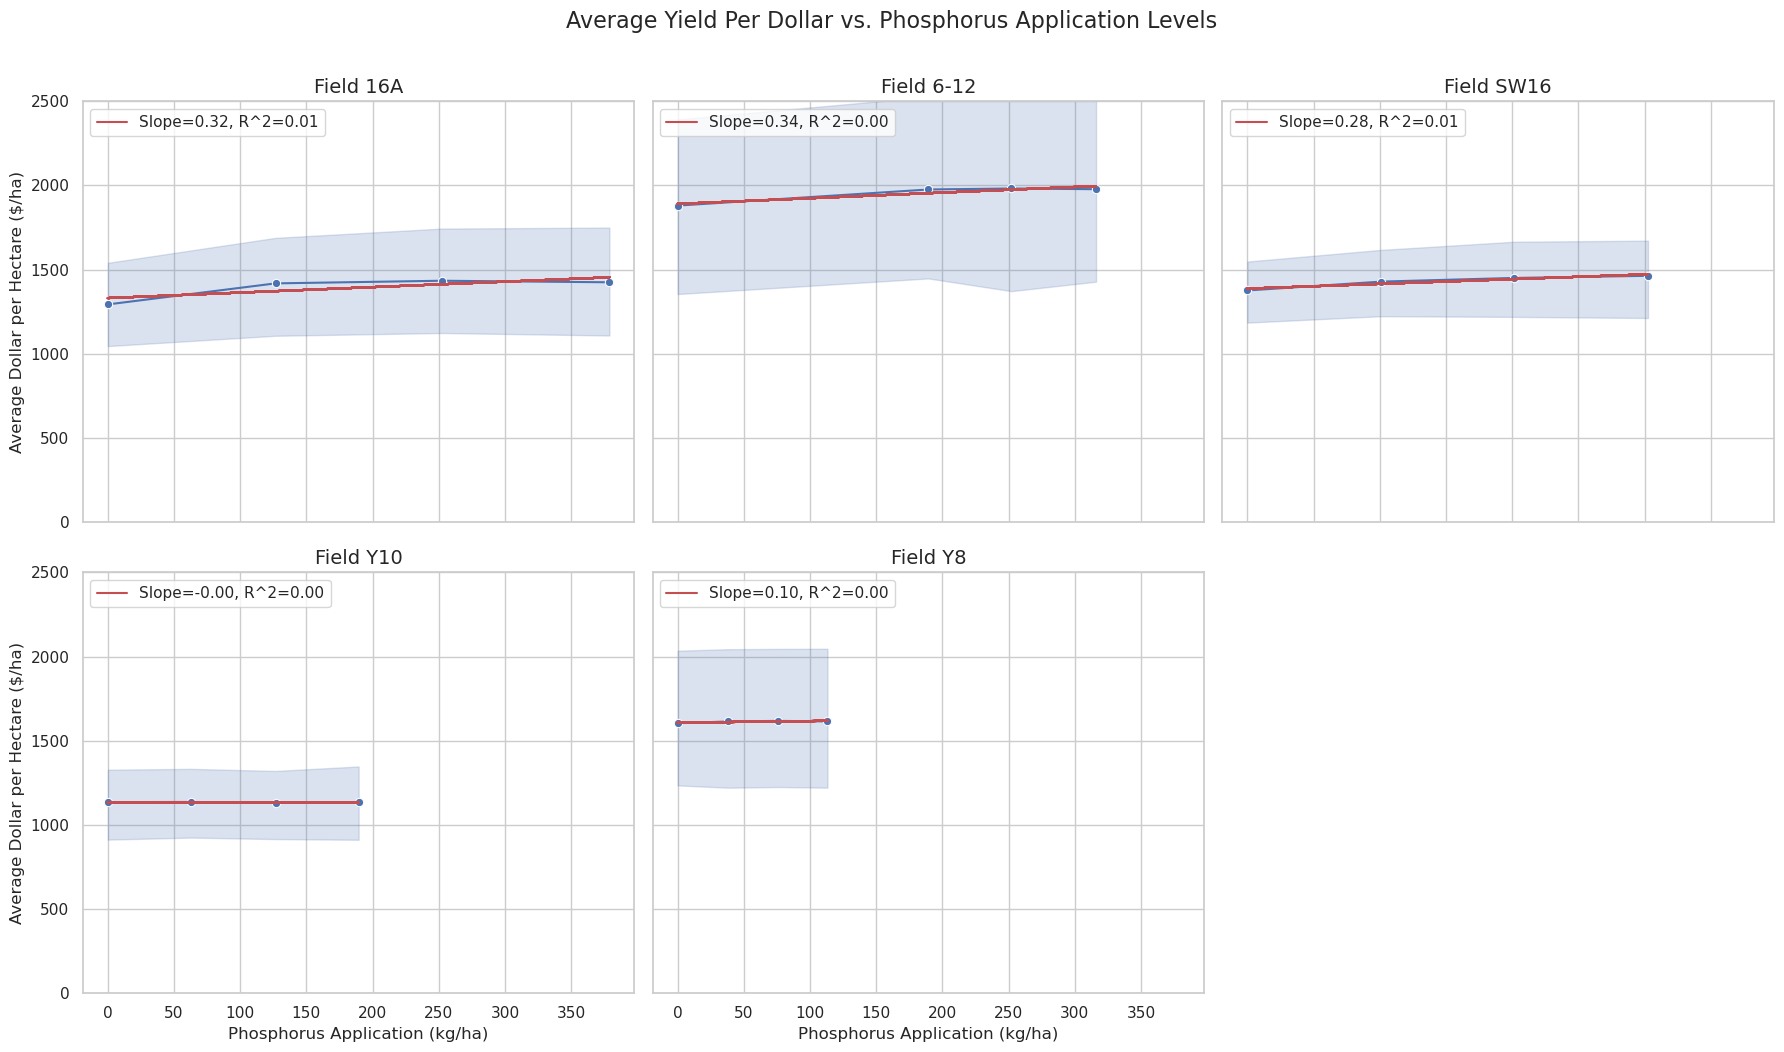

In [48]:
# Converting to kg/ha
plotting_df['x_metric'] = plotting_df['x']*0.45359/0.0404686

# Set the style of Seaborn for better visualization
sns.set_style("whitegrid")

# Create a figure and axes for the subplots in a 2x3 grid
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10), sharey=True, sharex = True)

# Flatten the axes array for easier iteration
axes_flat = axes.flatten()

# Iterate over each unique field
fields = plotting_df['field'].unique()

for index, field in enumerate(fields):
    # Filter the dataframe for the current field
    field_df = plotting_df[plotting_df['field'] == field].copy()
    
    # Plotting the line plot for the current field
    sns.lineplot(x='x_metric', y='dollars_per_ha_minus_cost', data=field_df, ax=axes_flat[index], marker='o')
    
    # Compute regression statistics
    slope, intercept, r_value, p_value, std_err = linregress(field_df['x_metric'], field_df['dollars_per_ha_minus_cost'])
    axes_flat[index].plot(field_df['x_metric'], intercept + slope*field_df['x_metric'], 'r', label=f'Slope={slope:.2f}, R^2={r_value**2:.2f}')
    
    # Set title for each subplot
    axes_flat[index].set_title(f'Field {field}', fontsize=14)
    
    # Display the legend for the current field's subplot
    axes_flat[index].legend(loc='upper left')
    
    # Set x and y labels for the first subplot only
    if index == 0 or index == 3:
        axes_flat[index].set_ylabel('Average Dollar per Hectare ($/ha)', fontsize=12)
    else:
        axes_flat[index].set_ylabel('')
    
    axes_flat[index].set_xlabel('Phosphorus Application (kg/ha)', fontsize=12)
    axes_flat[index].set_ylim(0, 2500)

# Remove the plot from the last subplot (making it empty)
axes_flat[-1].axis('off')

plt.tight_layout()
plt.suptitle('Average Yield Per Dollar vs. Phosphorus Application Levels', fontsize=16, y=1.05)
plt.savefig('Output/Figures/Economics_rf_total_revenue.jpg', bbox_inches = 'tight', dpi = 300)